In [1]:
import pandas as pd
import numpy as np
import dgl
from dgl.data import DGLDataset
import torch
import os
from torch_geometric.nn import GCNConv, GraphConv, GATConv, GatedGraphConv
import dgl.data
import dgl.function as fn
from dgl.nn.pytorch.conv.sageconv import SAGEConv
# from loss import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
from sklearn.metrics import roc_auc_score

def unique(list1):
    x = np.array(list1)
    return np.unique(x)

data_dir  = './bill_challenge_datasets'
train_graph = pd.read_csv(f'{data_dir}/Training/training_graph.csv')
page_label = pd.read_csv(f'{data_dir}/Training/node_classification.csv')
iso_nodes = pd.read_csv(f'{data_dir}/Training/isolated_nodes.csv')
iso_nodes = list(iso_nodes.nodes)

class BDCDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='BDCDataset')

    def process(self):
        node_set = {1}
        for index, row in train_graph.iterrows():
            if row.node1 != row.node2:
                node_set.update([row.node1, row.node2])
        node_list = list(node_set)
        node_to_index  = {node: index for index, node in enumerate(node_list)}

        # construct edges (consecutive integers starting from 0)
        edges_src, edges_dst = [], []
        for index, row in train_graph.iterrows():
            if row.node1 != row.node2:
                edges_src.append(node_to_index[row.node1])
                edges_dst.append(node_to_index[row.node2])
        edges_src = torch.from_numpy(np.array(edges_src))
        edges_dst = torch.from_numpy(np.array(edges_dst))
        # construct labels and features
        node_feature = pd.read_csv('node_feature_20.csv')
        node_feature['d2v'] = node_feature['d2v'].apply(lambda x: np.fromstring(x.replace('\n','').replace('[','').replace(']','').replace('  ',' '), sep=' '))
        for index, row in node_feature.iterrows():
            try:
                node_feature.loc[index, 'id'] = node_to_index[node_feature.loc[index, 'id']]
            except:
                node_feature = node_feature.drop(index)
                
        node_labels = torch.from_numpy(node_feature['label'].to_numpy())
        node_d2v = torch.from_numpy(np.stack(list(node_feature['d2v']), axis=0))
                
        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=len(node_list))
        self.graph.ndata['label'] = node_labels
        self.graph.ndata['feat'] = node_d2v
        # self.graph.edata['weight'] = edge_features

        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = len(node_list)
        n_train = int(n_nodes * 0.8)
        n_val = int(n_nodes * 0.2)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train:] = True
        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

dataset = BDCDataset()
g = dataset[0]
g = dgl.to_bidirected(g, copy_ndata=True)
u, v = g.edges()

eids = np.arange(g.number_of_edges())  # [0 to num-1]
eids = np.random.permutation(eids)  # permutation
# cross validation

test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]  # test set of pos edge
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]  # train set of pos edge

adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]
train_g = dgl.remove_edges(g, eids[:test_size])
print('f=========================')

class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = F.normalize(h)
        return h

# class GraphSAGE(nn.Module):
#     def __init__(self, in_feats, h_feats):
#         super(GraphSAGE, self).__init__()
#         self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
#         self.conv2 = SAGEConv(h_feats, 2*h_feats, 'mean')
#         self.conv3 = SAGEConv(2*h_feats, 4*h_feats, 'mean')
        

#     def forward(self, g, in_feat):
#         h = self.conv1(g, in_feat)
#         h = F.relu(h)
#         h = self.conv2(g, h)
#         h = F.relu(h)
#         h = self.conv3(g, h)
#         h = F.normalize(h)
#         return h


# The model then predicts the probability of existence of an edge
# by computing a score between the representations of both incident
# nodes with a function (e.g. an MLP or a dot product),
# which you will see in the next section.

train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]
        
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats).double()
        self.W2 = nn.Linear(h_feats, 1).double()
        # self.W1 = nn.Linear(h_feats, 1).double()
        

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}
        # return {'score': self.W1(h).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']
        
print('================Building model=================')
expand_factor = 32
model = GraphSAGE(train_g.ndata['feat'].shape[1], expand_factor)
# You can replace DotPredictor with MLPPredictor.
pred = MLPPredictor(expand_factor)
# pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

optimizer = torch.optim.AdamW(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #
all_logits = []
model = model.double()
for e in range(1000):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    # model = model.float()
    # h = h.float()
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 10 == 0:
        val_pos_score = pred(test_pos_g, h)
        val_neg_score = pred(test_neg_g, h)
        val_loss = compute_loss(val_pos_score, val_neg_score)
        print('In epoch {}, loss: {}, val_loss'.format(e, loss, val_loss))



Using backend: pytorch


f=========================
================Building model=================
In epoch 0, loss: 0.7005462646484375, val_loss
In epoch 10, loss: 0.5764901638031006, val_loss
In epoch 20, loss: 0.4829997420310974, val_loss
In epoch 30, loss: 0.4318169355392456, val_loss
In epoch 40, loss: 0.38695287704467773, val_loss
In epoch 50, loss: 0.34677132964134216, val_loss
In epoch 60, loss: 0.32308781147003174, val_loss
In epoch 70, loss: 0.30966809391975403, val_loss
In epoch 80, loss: 0.3001137375831604, val_loss
In epoch 90, loss: 0.2926653027534485, val_loss
In epoch 100, loss: 0.2875547409057617, val_loss
In epoch 110, loss: 0.27473145723342896, val_loss
In epoch 120, loss: 0.2535255551338196, val_loss
In epoch 130, loss: 0.23294518887996674, val_loss
In epoch 140, loss: 0.2191043645143509, val_loss
In epoch 150, loss: 0.20373713970184326, val_loss
In epoch 160, loss: 0.18621307611465454, val_loss
In epoch 170, loss: 0.1748679131269455, val_loss
In epoch 180, loss: 0.1665271520614624, val_lo

In [2]:
# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

AUC 0.9832964086818513


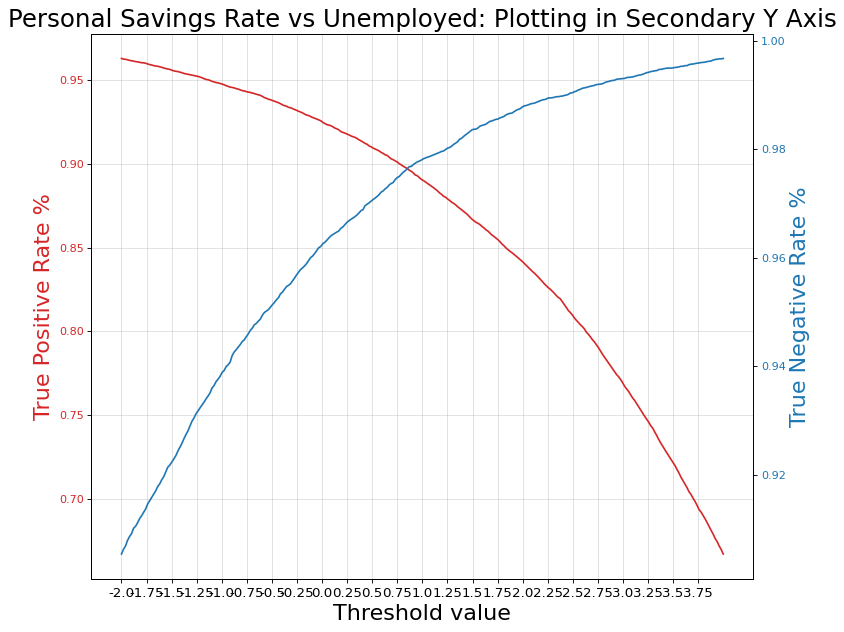

In [3]:
thresh = np.linspace(-2, 4, num=300)
nacc, pacc = [], []
for t in thresh:
    nacc.append( np.sum(np.array(neg_score) <= t, axis=0) / len(neg_score) )
    pacc.append( np.sum(np.array(pos_score) >= t, axis=0) / len(neg_score) )
    
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax1 = plt.subplots(1,1,figsize=(10,8), dpi= 80)
ax1.plot(thresh, pacc, color='tab:red')

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(thresh, nacc, color='tab:blue')

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Threshold value', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('True Positive Rate %', color='tab:red', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("True Negative Rate %", color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_xticks(np.arange(thresh[0], thresh[-1], 0.25))
ax2.set_xticklabels(np.arange(thresh[0], thresh[-1], 0.25), rotation=90, fontdict={'fontsize':10})
ax2.set_title("Personal Savings Rate vs Unemployed: Plotting in Secondary Y Axis", fontsize=22)
fig.tight_layout()
plt.show()

# plt.plot(thresh, nacc)
# plt.plot(thresh, pacc)


AUC 0.9955108739873183


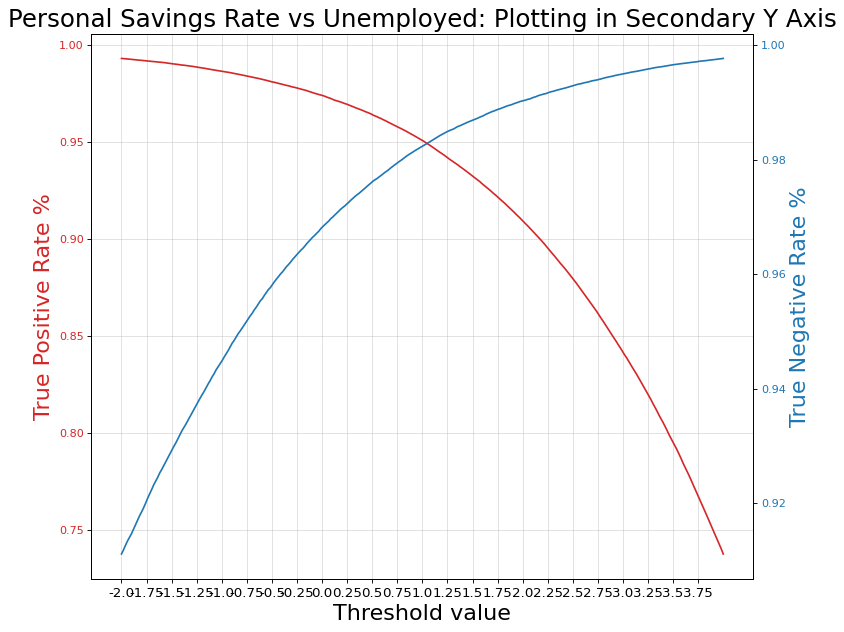

In [4]:
# trainset fitting
with torch.no_grad():
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

thresh = np.linspace(-2, 4, num=300)
nacc, pacc = [], []
for t in thresh:
    nacc.append( np.sum(np.array(neg_score) <= t, axis=0) / len(neg_score) )
    pacc.append( np.sum(np.array(pos_score) >= t, axis=0) / len(neg_score) )
    
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax1 = plt.subplots(1,1,figsize=(10,8), dpi= 80)
ax1.plot(thresh, pacc, color='tab:red')

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(thresh, nacc, color='tab:blue')

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Threshold value', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('True Positive Rate %', color='tab:red', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("True Negative Rate %", color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_xticks(np.arange(thresh[0], thresh[-1], 0.25))
ax2.set_xticklabels(np.arange(thresh[0], thresh[-1], 0.25), rotation=90, fontdict={'fontsize':10})
ax2.set_title("Personal Savings Rate vs Unemployed: Plotting in Secondary Y Axis", fontsize=22)
fig.tight_layout()
plt.show()

In [5]:
neg_eids

array([316746836, 130501232, 193883557, ..., 135862485, 342690277,
       398956560])

In [6]:
node_set = {1}
for index, row in train_graph.iterrows():
    if row.node1 != row.node2:
        node_set.update([row.node1, row.node2])
node_list = list(node_set)
node_to_index  = {node: index for index, node in enumerate(node_list)}

In [7]:
# test_labels = pd.read_csv(f'{data_dir}/Test_Dataset/test_edges.csv')
test_labels = pd.read_csv('./bill_challenge_datasets/Test Dataset/test_edges.csv')
# test_labels = list(test_labels.label)
a = list(test_labels.node1)
b = list(test_labels.node2)
outlier = []
valid = []
u1, v1 = [], []
for idx,x in enumerate(a):
    try:
        node_to_index[a[idx]]
        node_to_index[b[idx]]
        valid.append(idx)
        u1.append(node_to_index[a[idx]])
        v1.append(node_to_index[b[idx]])
    except:
        outlier.append(idx)
        
u1 = torch.from_numpy(np.array(u1))
v1 = torch.from_numpy(np.array(v1))
print(len(u1))
print(len(v1))
test_G = dgl.graph((u1, v1), num_nodes=g.number_of_nodes())

45125
45125


In [8]:
thresh = 1.1
res = pred(test_G, h)>thresh
GT_labels = pd.read_csv('./bill_challenge_datasets/Test Dataset/test_labels.csv')
GT_labels = list(GT_labels.label)
right = 0
for i,idx in enumerate(valid):
    if GT_labels[idx]==1 and res[i]==True:
        right += 1
    elif GT_labels[idx]==0 and res[i]==False:
        right +=1
acc = right/len(valid)
print(acc)

0.9129972299168975
